In [27]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, CategoricalArrays
using Plots
using Distributions

In [28]:
const GRB_ENV = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19


In [29]:
# unpaired single penalty
RHO = -0.5;

In [31]:
# loading data
df = CSV.read("imputed_table.csv", DataFrame)[:, 2:end];
people = CSV.read("people.csv", DataFrame);

In [6]:
people_df = people;

In [7]:
preference_df = df[1:20, 1:20]

Row,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.12573,-0.132105,0.640423,0.1049,-0.535669,0.361595,1.304,0.947081,-0.703735,-1.26542,0.911465,0.911465,0.911465,0.911465,-0.607644,-1.3672,-0.607644,-1.3672,0.911465,-0.607644
2,-0.504199,0.357955,0.414866,-1.24978,0.175539,-0.320363,-1.90409,0.958407,-0.361859,-0.85239,-0.628109,0.157027,-0.628109,0.549595,0.942163,-0.628109,1.33473,-1.41324,-1.02068,1.33473
3,0.937358,0.21877,0.339794,1.39214,0.31772,0.545022,0.99023,1.63326,1.22704,0.377215,-0.474342,-0.474342,-0.474342,-0.474342,1.89737,-0.474342,-0.474342,-0.474342,1.89737,-0.474342
4,0.135331,0.261963,0.7203,-0.553811,-1.29184,-1.6005,0.553141,0.710291,-0.875758,-0.528035,-0.350857,0.584761,-1.28647,0.818665,0.116952,-1.28647,-0.818665,-0.350857,0.818665,1.75428
5,-1.23944,0.00437185,0.335725,1.19403,2.65828,-0.396796,-0.877103,1.06017,0.213009,2.00638,-0.327327,-0.981981,-0.981981,0.654654,-0.327327,0.0,-0.654654,-0.654654,1.30931,1.96396
6,-0.613547,1.13328,-0.784445,0.119175,-0.284907,0.00117764,-0.559545,0.43814,-0.73985,0.112521,-0.116093,0.270883,-0.309581,1.04484,-1.08353,-1.85748,0.657859,-0.696557,1.04484,1.04484
7,0.450715,-0.226007,0.66004,-1.7661,-0.100062,0.861031,0.479559,-0.283624,0.325463,1.75672,0.2243,0.2243,0.2243,1.3458,-1.27103,-1.27103,1.3458,-1.27103,-0.149533,0.598134
8,-0.489866,0.541139,-0.336873,0.770053,0.983356,1.98303,-0.412383,0.77458,1.0426,0.242193,-1.5,1.5,-0.75,-0.75,0.0,0.0,0.0,-0.75,0.75,1.5
9,-0.234397,1.84195,0.398938,-1.88541,-1.23653,1.51647,-0.0490567,0.173675,-1.1627,1.54386,-1.34164,2.01246,0.67082,0.0,-1.34164,-0.67082,0.0,0.0,0.0,0.67082


# Model 1: Pairs of 2

In [59]:
N = size(preference_df, 1);
M = size(preference_df, 2);

In [77]:
num_religions = 10 # my what a controversial statement!

10

In [105]:
m1 = Model(() -> Gurobi.Optimizer(GRB_ENV))

# Create variables
@variable(m1, z[1:N, 1:M], Bin)
@variable(m1, t[1:N, 1:M], Bin)

# Create objective
@objective(m1, Min, -1 * sum(z[i,j] * (preference_df[i,j] + preference_df[j,i]) for i in 1:size(preference_df)[1], j in i:size(preference_df)[2]) + (size(preference_df)[1] - sum(z)) * -RHO)

# Create constraints

# Each person can only be matched with one person
@constraint(m1, [i=1:N], sum(z[i,j] for j in 1:M) <= 1)
@constraint(m1, [j=1:M], sum(z[i,j] for i in 1:N) <= 1)

# Make sure that if i is matched with j, then j is matched with i
# Different gender matching
# People with strong religious preferences are matched with someone sharing the same religious preference
religion_df = Matrix(people_df[:, [:agnostic, :atheist, :buddhist, :catholic, :hindu, :jewish, :mormon, :muslim, :protestant, :unaffiliated]])

for i in 1:size(z, 1)
    for j in i:size(z, 2)
        @constraint(m1, z[i,j] == z[j,i])
        @constraint(m1, (people_df[i, :gender] + people_df[j, :gender] - 1) * z[i,j] ==0 )

        @constraint(m1, [i=1:N,j=1:M], sum(religion_df[i, k] * religion_df[j, k] for k in 1:num_religions) >= 2*z[i,j]*t[i,j])
        #@constraint(m1, (1 - sum(religion_df[i, k] * religion_df[j, k] for k in 1:size(religion_df)[2])) * t[i,j] * z[i,j] <= 0)
        @constraint(m1, t[i,j] >= people_df[i, :imprelig])
        @constraint(m1, t[i,j] >= people_df[j, :imprelig])
    end
end

optimize!(m1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 880 rows, 800 columns and 1710 nonzeros
Model fingerprint: 0xd02f9b95
Model has 84000 quadratic constraints
Variable types: 0 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e+00, 2e+00]
  Objective range  [4e-03, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+00, 1e+00]
Found heuristic solution: objective 10.0000000
Presolve removed 861 rows and 530 columns
Presolve time: 0.03s
Presolved: 379 rows, 450 columns, 900 nonzeros
Variable types: 0 continuous, 450 integer (450 binary)

Root relaxation: objective -1.424709e+01, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [106]:
objective_value(m1)

-14.247090067598343

## Some Visualizations

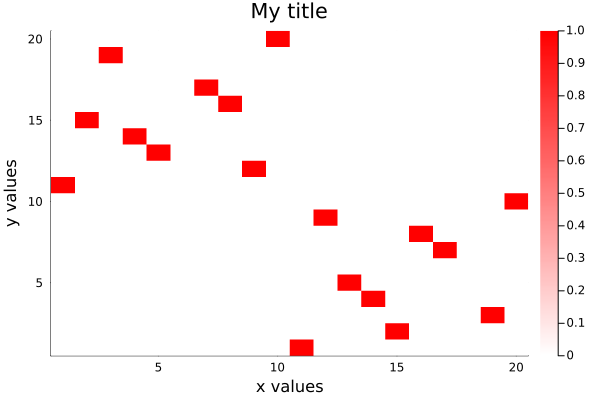

In [107]:
opt_z = value.(z)
opt_z[1:20,1:20]
heatmap(1:size(opt_z,1),
    1:size(opt_z,2), opt_z,
    c=cgrad([:white,:red,]),
    xlabel="x values", ylabel="y values",
    title="My title")

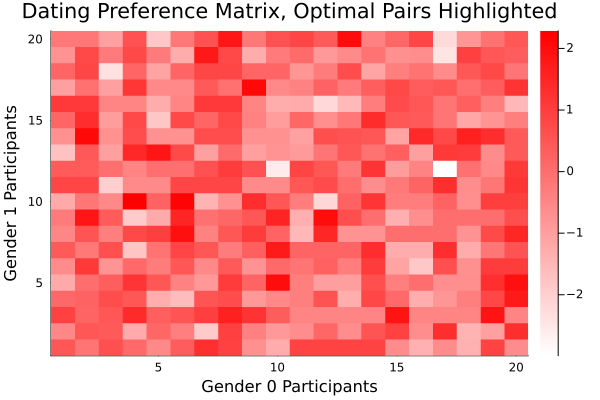

In [108]:
preference_df
heatmap(1:size(preference_df,1),
    1:size(preference_df,2), preference_df,
    c=cgrad([:white,:red,]),
    xlabel="Gender 0 Participants", ylabel="Gender 1 Participants",
    title="Dating Preference Matrix, Optimal Pairs Highlighted")


In [109]:
write_to_file(m1, "model_orig.lp")

In [110]:
MOI.get(m1, Gurobi.ModelAttribute("IsMIP"))

In [37]:
zij = value.(z);

sum(zij, dims=1)

1×551 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [ ]:
CSV.write("z.csv", Tables.table(zij))

## Model 1.5: Pairs of 2 With Robustness

In [118]:
m1_5 = Model(() -> Gurobi.Optimizer(GRB_ENV))

# Create variables
@variable(m1_5, z[1:N, 1:M], Bin)
@variable(m1_5, t[1:N, 1:M], Bin)

# Create objective
@objective(m1_5, Min, -1 * sum(z[i,j] * (preference_df[i,j]-0.5 + preference_df[j,i]-0.5) for i in 1:size(preference_df)[1], j in i:size(preference_df)[2]) + (size(preference_df)[1] - sum(z)) * -RHO)

# Create constraints

# Each person can only be matched with one person
@constraint(m1_5, [i=1:N], sum(z[i,j] for j in 1:M) <= 1)
@constraint(m1_5, [j=1:M], sum(z[i,j] for i in 1:N) <= 1)

# Make sure that if i is matched with j, then j is matched with i
# Different gender matching
# People with strong religious preferences are matched with someone sharing the same religious preference
religion_df = Matrix(people_df[:, [:agnostic, :atheist, :buddhist, :catholic, :hindu, :jewish, :mormon, :muslim, :protestant, :unaffiliated]])

for i in 1:size(z, 1)
    for j in i:size(z, 2)
        @constraint(m1_5, z[i,j] == z[j,i])
        @constraint(m1_5, (people_df[i, :gender] + people_df[j, :gender] - 1) * z[i,j] ==0 )

        @constraint(m1_5, [i=1:N,j=1:M], sum(religion_df[i, k] * religion_df[j, k] for k in 1:num_religions) >= 2*z[i,j]*t[i,j])
        #@constraint(m1, (1 - sum(religion_df[i, k] * religion_df[j, k] for k in 1:size(religion_df)[2])) * t[i,j] * z[i,j] <= 0)
        @constraint(m1_5, t[i,j] >= people_df[i, :imprelig])
        @constraint(m1_5, t[i,j] >= people_df[j, :imprelig])
    end
end

optimize!(m1_5)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 880 rows, 800 columns and 1710 nonzeros
Model fingerprint: 0xd5945555
Model has 84000 quadratic constraints
Variable types: 0 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e+00, 2e+00]
  Objective range  [8e-03, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+00, 1e+00]
Found heuristic solution: objective 10.0000000
Presolve removed 861 rows and 530 columns
Presolve time: 0.03s
Presolved: 379 rows, 450 columns, 900 nonzeros
Variable types: 0 continuous, 450 integer (450 binary)

Root relaxation: objective -5.851620e+00, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [119]:
objective_value(m1_5)

-5.851619698569166

# Model 2: Allow each person to pair with 2 people, no enforced closed groups

In [39]:
preference_df = Matrix(df[1:20, 1:20]);
preference_df[diagind(preference_df)] .= -RHO;

people_df = people;

In [16]:
m2 = Model(() -> Gurobi.Optimizer(GRB_ENV))

# Create variables
@variable(m2, z[1:size(preference_df, 1), 1:size(preference_df, 2)], Bin)
@variable(m2, t[1:size(preference_df, 1), 1:size(preference_df, 2)], Bin)

# Create objective
@objective(m2, Min, -1 * sum(z[i,j] * (preference_df[i,j] + preference_df[j,i]) for i in 1:size(preference_df, 1), j in i:size(preference_df, 1)) + (size(preference_df, 1) - sum(z)) * RHO)

# Create constraints

# Each person can only be matched with two people
@constraint(m2, [i=1:size(preference_df, 1)], sum(z[i,j] for j in i:size(preference_df, 1)) <= 2)
@constraint(m2, [j=1:size(preference_df, 1)], sum(z[i,j] for i in 1:size(preference_df, 1)) <= 2)

#@constraint(m1, [k=1:size(preference_df, 1)], sum(z[i,j,k] for i in 1:size(preference_df, 1) for j in 1:size(preference_df, 1)) <= 2)

#religion_df = Matrix(people_df[:, [:agnostic, :atheist, :buddhist, :catholic, :hindu, :jewish, :mormon, :muslim, :protestant, :unaffiliated]])

for i in 1:size(z, 1)
    for j in i:size(z, 1)

        # Make sure that if i is matched with j, then j is matched with i
        @constraint(m2, z[i,j] == z[j, i])

        # Different gender matching
        @constraint(m2, (people_df[i, :gender] + people_df[j, :gender] - 1) * z[i,j] ==0 ) 

        # People with strong religious preferences are matched with someone sharing the same religious preference
        # @constraint(m1, (1 - sum(religion_df[i, k] * religion_df[j, k] for k in 1:size(religion_df)[2])) * t[i,j] * z[i,j] <= 0)
        # @constraint(m1, t[i,j] >= people_df[i, :imprelig])
        # @constraint(m1, t[i,j] >= people_df[j, :imprelig])
    end
end

# for i in 1:size(z, 1)
#     for j in i:size(z, 2)
#         @constraint(m1, z[j,i,j] ==0)
#         @constraint(m1, z[j,j,i] ==0)
#         for k in j:size(z, 3)
#             @constraint(m1, z[i,k,j] ==0)
#             @constraint(m1, z[j,k,i] ==0)
#             @constraint(m1, z[k,i,j] ==0)
#             @constraint(m1, z[k,j,i] ==0)
#             @constraint(m1, z[j,i,k] ==0)
#         end
#     end
# end

optimize!(m2)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 460 rows, 800 columns and 1100 nonzeros
Model fingerprint: 0x21383dd7
Variable types: 0 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-03, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -10.0000000
Presolve removed 452 rows and 780 columns
Presolve time: 0.00s
Presolved: 8 rows, 20 columns, 32 nonzeros
Found heuristic solution: objective -23.6744312
Variable types: 0 continuous, 20 integer (20 binary)
Found heuristic solution: objective -24.7943220

Root relaxation: cutoff, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0   

In [17]:
zij = value.(z);

In [18]:
sum(zij)

24.0

In [19]:
CSV.write("z2.csv", Tables.table(zij))

"z2.csv"

### Requiring closed groups.

In [20]:
# preference_df = Matrix(df[1:10, 1:10]);
# preference_df[diagind(preference_df)] .= -RHO;

# people_df = people;

In [21]:
# m2 = Model(() -> Gurobi.Optimizer(GRB_ENV))

# # Create variables
# @variable(m2, z[1:size(preference_df, 1), 1:size(preference_df, 2)], Bin)
# @variable(m2, t[1:size(preference_df, 1), 1:size(preference_df, 2)], Bin)

# # Create objective
# @objective(m2, Min, -1 * sum(z[i,j] * (preference_df[i,j] + preference_df[j,i]) for i in 1:size(preference_df, 1), j in i:size(preference_df, 1)) )#+ (size(preference_df, 1) - sum(z)) * -RHO)

# # Create constraints

# # Each person can only be matched with two people
# @constraint(m2, [i=1:size(preference_df, 1)], sum(z[i,j] for j in i:size(preference_df, 1)) <= 2)
# @constraint(m2, [j=1:size(preference_df, 1)], sum(z[i,j] for i in 1:size(preference_df, 1)) <= 2)


# #@constraint(m1, [k=1:size(preference_df, 1)], sum(z[i,j,k] for i in 1:size(preference_df, 1) for j in 1:size(preference_df, 1)) <= 2)

# #religion_df = Matrix(people_df[:, [:agnostic, :atheist, :buddhist, :catholic, :hindu, :jewish, :mormon, :muslim, :protestant, :unaffiliated]])

# for i in 1:size(z, 1)
#     for j in i:size(z, 1)

#         # Make sure that if i is matched with j, then j is matched with i
#         @constraint(m2, z[i,j] == z[j, i])

#         # Different gender matching
#         #@constraint(m2, (people_df[i, :gender] + people_df[j, :gender] - 1) * z[i,j] ==0 )
        

#         # People with strong religious preferences are matched with someone sharing the same religious preference
#         # @constraint(m1, (1 - sum(religion_df[i, k] * religion_df[j, k] for k in 1:size(religion_df)[2])) * t[i,j] * z[i,j] <= 0)
#         # @constraint(m1, t[i,j] >= people_df[i, :imprelig])
#         # @constraint(m1, t[i,j] >= people_df[j, :imprelig])
#     end
#     @constraint(m2, z[i,i] ==0)
# end

# # for i in 1:size(z, 1)
# #     for j in i:size(z, 2)
# #         @constraint(m1, z[j,i,j] ==0)
# #         @constraint(m1, z[j,j,i] ==0)
# #         for k in j:size(z, 3)
# #             @constraint(m1, z[i,k,j] ==0)
# #             @constraint(m1, z[j,k,i] ==0)
# #             @constraint(m1, z[k,i,j] ==0)
# #             @constraint(m1, z[k,j,i] ==0)
# #             @constraint(m1, z[j,i,k] ==0)
# #         end
# #     end
# # end

# optimize!(m2)

In [22]:
zij = value.(z)

20×20 Matrix{Float64}:
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      1.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   1.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   1.0  1.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   1.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   0.0  1.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   1.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   0.0  0.0
  1.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  0.0
  0.0   1.0   0

In [23]:
RHO=1
preference_df = Matrix(df);
preference_df[diagind(preference_df)] .= -RHO;

people_df = people;

In [24]:
m3 = Model(() -> Gurobi.Optimizer(GRB_ENV))

# Create variables
@variable(m3, z[1:size(preference_df, 1), 1:size(preference_df, 1), 1:size(preference_df, 1)], Bin)
@variable(m3, t[1:size(preference_df, 1), 1:size(preference_df, 1), 1:size(preference_df, 1)], Bin)

# Create objective
#@objective(m3, Min, -1 * sum(z[i,j,k] * (preference_df[i,j] + preference_df[j,i] + preference_df[j,k] + preference_df[k,j] + preference_df[i,k] + preference_df[k,i]) for i in 1:size(preference_df, 1), j in 1:size(preference_df, 1), k in 1:size(preference_df, 1)) )
@objective(m3, Min, -1 * sum(z[i,j,k] * (preference_df[i,j] + preference_df[j,i] + preference_df[j,k] + preference_df[k,j] + preference_df[i,k] + preference_df[k,i]) for i in 1:size(preference_df, 1), j in i:size(preference_df, 1), k in j+1:size(preference_df, 1)) +
    (fld(size(preference_df, 1), 3) + size(preference_df, 1)%3 - sum(z)) * RHO)

# Create constraints

# Each person can only be matched with two people
@constraint(m3, [i=1:size(preference_df, 1)], sum(z[i,j,k] for j in 1:size(preference_df, 1), k in 1:size(preference_df, 1)) <= 2)
@constraint(m3, [j=1:size(preference_df, 1)], sum(z[i,j,k] for i in 1:size(preference_df, 1), k in 1:size(preference_df, 1)) <= 2)
@constraint(m3, [k=1:size(preference_df, 1)], sum(z[i,j,k] for i in 1:size(preference_df, 1), j in 1:size(preference_df, 1)) <= 2)

#@constraint(m3, [i=1:size(preference_df, 1)], sum(z[i,k,k] for k in 1:size(preference_df, 1)) <= 1)
#@constraint(m3, [k=1:size(preference_df, 1)], sum(z[k,j,k] for j in 1:size(preference_df, 1)) == 0)
#@constraint(m3, [k=1:size(preference_df, 1)], sum(z[i,k,k] for i in 1:size(preference_df, 1)) == 0)

#@constraint(m1, [k=1:size(preference_df, 1)], sum(z[i,j,k] for i in 1:size(preference_df, 1) for j in 1:size(preference_df, 1)) <= 2)

#religion_df = Matrix(people_df[:, [:agnostic, :atheist, :buddhist, :catholic, :hindu, :jewish, :mormon, :muslim, :protestant, :unaffiliated]])

for i in 1:size(z, 1)
    for j in i:size(z, 1)
        for k in j:size(z, 3)

            # Make sure that if i is matched with j, then j is matched with i
            @constraint(m3, z[i,j, k] == z[j,i,k])
            @constraint(m3, z[i,j, k] == z[j,k,i])
            @constraint(m3, z[i,j, k] == z[k,j,i])
            @constraint(m3, z[i,j, k] == z[k,i,j])
            @constraint(m3, z[i,j, k] == z[i,k,j])

            # Different gender matching. >1 girl > 1 guy
            @constraint(m3, (people_df[i, :gender] + people_df[j, :gender] + people_df[k, :gender] - 2) * z[i,j,k] <=0 )
            @constraint(m3, (people_df[i, :gender] + people_df[j, :gender] + people_df[k, :gender] - 1) * z[i,j,k] >=0 )

            # People with strong religious preferences are matched with someone sharing the same religious preference
            # @constraint(m1, (1 - sum(religion_df[i, k] * religion_df[j, k] for k in 1:size(religion_df)[2])) * t[i,j] * z[i,j] <= 0)
            # @constraint(m1, t[i,j] >= people_df[i, :imprelig])
            # @constraint(m1, t[i,j] >= people_df[j, :imprelig])
        end
    end
end

optimize!(m3)

LoadError: InterruptException:

In [25]:
zij = value.(z)

20×20 Matrix{Float64}:
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      1.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   1.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   1.0  1.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   1.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   0.0  1.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   1.0   0.0   0.0  0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0      0.0   0.0   0.0   0.0   0.0  0.0
  1.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  0.0
  0.0   1.0   0